In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('ggplot')

# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from optimization.utils import build_F, calculate_SSE, convert_ivp_results
from model.semi_batch import SemiBatchReactor
from optimization.model_optimization import ProfileOptimizer
from optimization.grid_search import ParameterGridSearch 
from bussineslogic.rto_data import RTODataModel
md = RTODataModel()


In [2]:
# Load the real model to generate samples
model_ideal = SemiBatchReactor()
# Get an instance of the profile and parameter optimizers
opt = ProfileOptimizer()
# Gets the optimal F
#f_real_optimum, u_real_optimum, _, _, _ = opt.run(model_ideal, 300, 40)
f_real_optimum = 0.5085
u_real_optimum = [18.6139787, 0.00110823, 227.6375114]



In [24]:
gs = ParameterGridSearch(lb=[0.021, 0.0026], ub=[0.15, 0.5120], N = 100)
model = SemiBatchReactor(k=[0.053, 0.128, 0.0, 0.0, 5])

u_test = [12.6139787, 0.00150823, 210.6375114]

samples = model_ideal.get_samples(u_real_optimum, [1.0], noise=False)
grid, results, pareto = gs.run(model, u_real_optimum, samples)

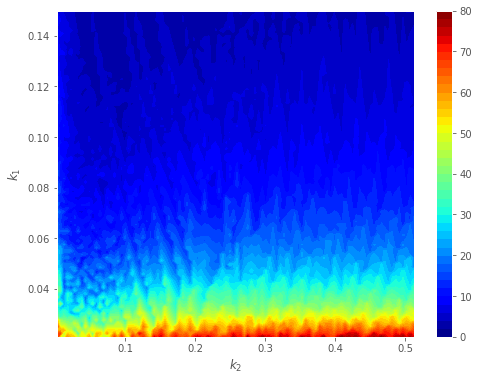

In [26]:
# Plot the grid search results
for key in grid.keys():
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    X, Y = grid[key]
    Z = results[key]
    cs = ax.contourf(X,Y,Z,cmap='jet', levels=50)
    fig.colorbar(cs)
    ax.set_xlabel('$k_2$')
    ax.set_ylabel('$k_1$')
    
    # ax = fig.add_subplot(122, projection='3d')
    # ax.plot_wireframe(X,Y,Z)

    #ax = fig.add_subplot(122, projection='3d')
    #ax.view_init(30, 30)
    #ax.plot_surface(X,Y,Z,cmap='jet')

plt.show()

In [4]:
#model_aprox = SemiBatchReactor(k=[0.053, 0.128, 0, 0, 5])
list_mean = []
list_rand = []

list_mean_min = []
list_rand_min = []

for i in range(20):
    f_mean, u_mean, _, fxk_mean, gxk_mean = opt.run(model_ideal, 200, 20, 'mean/1/bin')
    f_rand, u_rand, _, fxk_rand, gxk_rand = opt.run(model_ideal, 200, 20, 'rand/1/bin')

    gxk_mean = np.asarray(gxk_mean)
    gxk_rand = np.asarray(gxk_rand)

    mean_fxk_mean = np.ma.array(np.asarray(fxk_mean), mask = gxk_mean).mean(axis=1)
    mean_fxk_rand = np.ma.array(np.asarray(fxk_rand), mask = gxk_rand).mean(axis=1)

    min_fxk_mean = np.ma.array(np.asarray(fxk_mean), mask = gxk_mean).min(axis=1)
    min_fxk_rand = np.ma.array(np.asarray(fxk_rand), mask = gxk_rand).min(axis=1)


    list_mean.append(mean_fxk_mean)
    list_rand.append(mean_fxk_rand)
    list_mean_min.append(min_fxk_mean)
    list_rand_min.append(min_fxk_rand)
    print('end :', i)


end : 0
end : 1
end : 2
end : 3
end : 4
end : 5
end : 6
end : 7
end : 8
end : 9
end : 10
end : 11
end : 12
end : 13
end : 14
end : 15
end : 16
end : 17
end : 18
end : 19


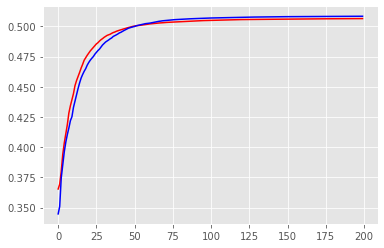

In [12]:
mean_fxk_mean = np.mean(np.asarray(list_mean).T, axis=1)
mean_fxk_rand = np.mean(np.asarray(list_rand).T, axis=1)
plt.plot(-mean_fxk_mean, 'r')
plt.plot(-mean_fxk_rand, 'b')

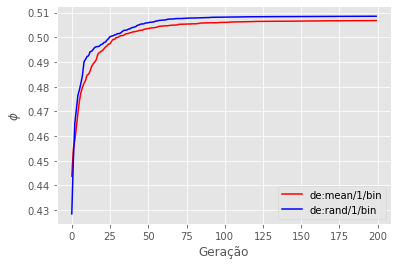

In [11]:
mean_fxk_mean = np.mean(np.asarray(list_mean_min).T, axis=1)
mean_fxk_rand = np.mean(np.asarray(list_rand_min).T, axis=1)
plt.plot(-mean_fxk_mean, 'r')
plt.plot(-mean_fxk_rand, 'b')
plt.ylabel('$\phi$')
plt.xlabel('Geração')
plt.legend(['de:mean/1/bin', 'de:rand/1/bin'])

In [27]:
all_results = pd.DataFrame(md.get_rto_results(5, 'two-step-paper'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id','iteration', 'var_name', 'value'])
all_results['instance'] = all_results['rto.name'].apply(lambda x: x.split(',')[0])

all_results_pv = pd.pivot_table(all_results, values='value', index=['instance','run.id','iteration'], columns=['var_name'], aggfunc=np.mean)
all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)
# kpis
all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_real_optimum)/u_real_optimum), axis=1)
all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * (x - f_real_optimum)/f_real_optimum)
all_results_pv['dPhi_iteration'] = all_results_pv[['cost_optmizer','cost_real']].apply(lambda x: 100*(x[0] - x[1])/x[1], axis=1)
all_results_pv['g_Cb_tf'] = all_results_pv['Cb_tf_real'].apply(lambda x: 'Não violada' if x <= 0.025 else 'Violada')
all_results_pv['g_Cd_tf'] = all_results_pv['Cd_tf_real'].apply(lambda x: 'Não violada' if x <= 0.15 else 'Violada')

In [28]:
all_results_pv.groupby(['instance']).aggregate(np.cumsum)

,run.id,iteration,Cb_tf_calibr,Cb_tf_init,Cb_tf_real,Cd_tf_calibr,Cd_tf_init,Cd_tf_real,Fs,cost_calibr,...,error_calibrator,k1_calibrated,k1_initial,k2_calibrated,k2_initial,tm,ts,du,dPhi,dPhi_iteration
0,607,0,0.002897,0.003117,0.003196,0.098519,0.102261,0.070050,0.000660,0.618420,...,0.652279,0.206400,0.053000,0.459371,0.128000,10.105360,196.078486,62.591021,-23.995615,29.929949
1,1216,1,0.016150,0.018397,0.015214,0.227736,0.238282,0.151802,0.001366,1.295105,...,1.370406,0.416277,0.182700,0.889651,0.421686,19.854691,421.638819,122.464733,-41.823262,80.988947
2,1827,3,0.018711,0.021330,0.016946,0.394073,0.400317,0.249120,0.002150,1.911368,...,2.189768,0.582528,0.390839,1.399131,0.866511,47.110965,601.169116,181.263515,-59.670373,142.968476
3,2440,6,0.027654,0.031501,0.023959,0.527884,0.538338,0.336892,0.002927,2.591130,...,3.067772,0.785169,0.578903,1.792048,1.336391,56.084964,809.642283,241.654219,-76.351529,198.159178
4,3055,10,0.055905,0.067461,0.046522,0.646691,0.663915,0.421703,0.003624,3.294181,...,3.954237,0.969348,0.763348,2.032459,1.787589,66.964903,1045.797687,297.521052,-92.686803,253.983962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,266131,1320,5.536640,6.046900,4.998041,42.256807,43.493736,27.839285,0.204205,207.104581,...,204.981084,60.022353,59.624330,108.720415,106.586631,6679.072578,67473.843963,16481.976207,-4312.593308,18401.040550
596,267325,1326,5.560804,6.071847,5.021121,42.404079,43.642217,27.933788,0.204884,207.807150,...,205.536769,60.233541,59.833815,109.117501,106.995514,6701.652903,67709.970910,16526.354190,-4326.692333,18461.299086
597,268521,1333,5.587569,6.098625,5.047139,42.528850,43.766988,28.022866,0.205605,208.523482,...,206.208446,60.432080,60.044968,109.372356,107.444171,6714.136467,67943.951020,16574.429504,-4341.264159,18520.693881
598,269719,1341,5.602110,6.116489,5.060164,42.680713,43.923040,28.121370,0.206243,209.212902,...,206.765385,60.634086,60.249832,109.792962,107.770141,6745.841095,68170.595450,16656.595543,-4355.719561,18585.363810


In [ ]:
all_results_pv.columns

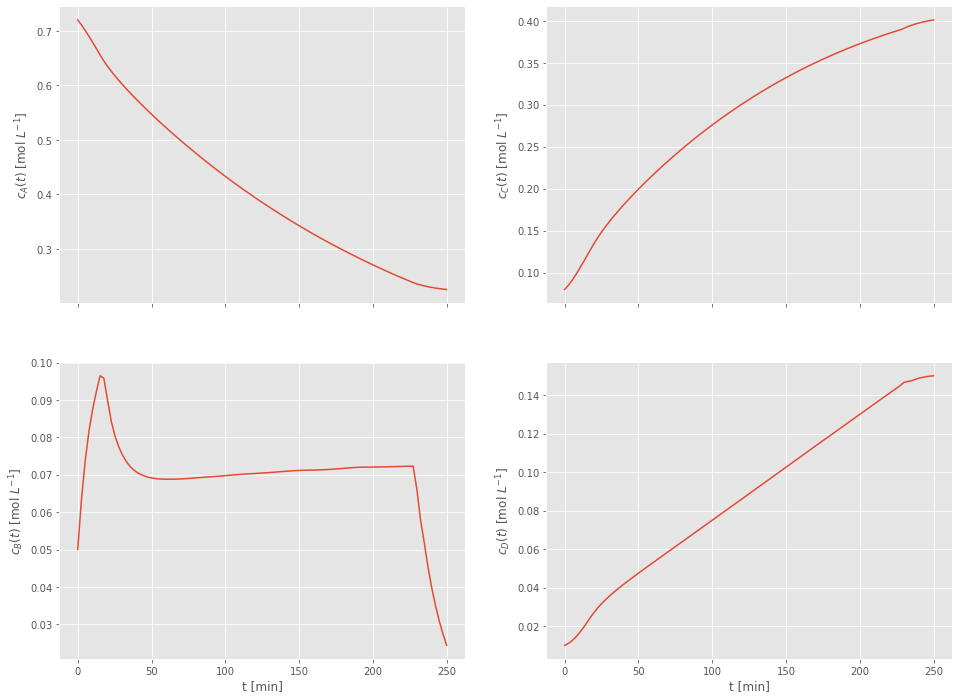

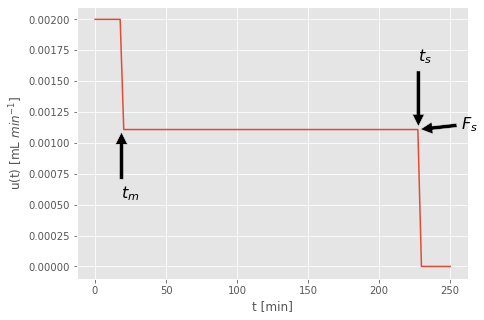

In [47]:
# ideal run
sim_ideal = model_ideal.simulate(u_real_optimum)

# Build the input signal F
F_ideal = build_F(sim_ideal.t, u_real_optimum)

# Plot the optimal simulation profiles
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, figsize=(16,12))

ax1[0].plot(sim_ideal.t, sim_ideal.y[0])
ax1[1].plot(sim_ideal.t, sim_ideal.y[2])
ax2[0].plot(sim_ideal.t, sim_ideal.y[1])
ax2[1].plot(sim_ideal.t, sim_ideal.y[3])
ax2[0].set_xlabel('t [min]')
ax2[1].set_xlabel('t [min]')

ax1[0].set_ylabel('$c_A(t)$ [mol $L^{-1}$]')
ax1[1].set_ylabel('$c_C(t)$ [mol $L^{-1}$]')
ax2[0].set_ylabel('$c_B(t)$ [mol $L^{-1}$]')
ax2[1].set_ylabel('$c_D(t)$ [mol $L^{-1}$]')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(sim_ideal.t, F_ideal)
#ax.axvline(u_real_optimum[0], 0, u_real_optimum[1]/0.002, color= 'k', ls='--')
#ax.axvline(u_real_optimum[2], 0, u_real_optimum[1]/0.002, color= 'k', ls='--')

ax.annotate('$t_m$', xy=(u_real_optimum[0], u_real_optimum[1]), xytext=(u_real_optimum[0], u_real_optimum[1] * 0.5),arrowprops=dict(facecolor='black', shrink=0.05),fontsize='16')
ax.annotate('$t_s$', xy=(u_real_optimum[2], u_real_optimum[1]), xytext=(u_real_optimum[2], u_real_optimum[1] * 1.5),arrowprops=dict(facecolor='black', shrink=0.05),fontsize='16')
ax.annotate('$F_s$', xy=(u_real_optimum[2], u_real_optimum[1]), xytext=(u_real_optimum[2] + 30, u_real_optimum[1]),arrowprops=dict(facecolor='black', shrink=0.05),fontsize='16')

ax.set_xlabel('t [min]')
ax.set_ylabel('u(t) [mL $min^{-1}$]')

plt.show()

In [ ]:
# du results per iteration
sns.boxplot(data=all_results_pv, x='iteration', y='du', hue='instance')
plt.title('')
plt.xlabel('# iteração')
plt.ylabel('$\Delta u\%$')
plt.show()

In [ ]:
# du results per instance
sns.boxplot(data=all_results_pv, x='instance', y='du')
plt.xlabel('Instância')
plt.ylabel('$\Delta u\%$')
plt.show()

In [ ]:
# dphi results per iteration
sns.boxplot(data=all_results_pv, x='iteration', y='dPhi', hue='instance')
plt.title('')
plt.xlabel('# iteração')
plt.ylabel('$\Delta \phi\%$')
plt.show()

In [ ]:
# dphi results per instance
sns.boxplot(data=all_results_pv, x='instance', y='dPhi')
plt.xlabel('Instância')
plt.ylabel('$\Delta \phi\%$')
plt.show()

In [ ]:
# lineplot dPhi
#sns.lineplot(data=all_results_pv, x='iteration', y='dPhi', hue='instance')
#plt.xlabel('# iteração')
#plt.ylabel('$\Delta \phi\%$')
#plt.show()

# plots du
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
sns.lineplot(data=all_results_pv, x='iteration', y='dPhi', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='dPhi', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('$\Delta \phi\%$')
ax[1].set_xlabel('instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# lineplot du
#sns.lineplot(data=all_results_pv, x='iteration', y='du', hue='instance')
#plt.xlabel('# iteração')
#plt.ylabel('$\Delta u\%$')
#plt.show()

# plots du
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
sns.lineplot(data=all_results_pv, x='iteration', y='du', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='du', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('$\Delta u\%$')
ax[1].set_xlabel('instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# plots k1
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
sns.lineplot(data=all_results_pv, x='iteration', y='k1_initial', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='k1_initial', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('$k_1$')
ax[1].set_xlabel('instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# plots k2
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
sns.lineplot(data=all_results_pv, x='iteration', y='k2_initial', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='k2_initial', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('$k_2$')
ax[1].set_xlabel('instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# plots error
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=all_results_pv, x='iteration', y='error_calibrator', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='error_calibrator', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('Erro')
ax[1].set_xlabel('Instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# plots Fs
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=all_results_pv, x='iteration', y='Fs', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='Fs', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('Fs')
ax[1].set_xlabel('Instância')
ax[1].set_ylabel('')
plt.show()


# plots ts
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=all_results_pv, x='iteration', y='ts', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='ts', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('ts')
ax[1].set_xlabel('Instância')
ax[1].set_ylabel('')
plt.show()

# plots tm
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=all_results_pv, x='iteration', y='tm', hue='instance', ax=ax[0])
sns.boxplot(data=all_results_pv, x='instance', y='tm', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('tm')
ax[1].set_xlabel('Instância')
ax[1].set_ylabel('')
plt.show()

In [ ]:
# convergence
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.countplot(data=all_results_pv, x='g_Cb_tf', hue='instance', ax=ax[0])
sns.countplot(data=all_results_pv, x='g_Cd_tf', hue='instance', ax=ax[1])

ax[0].set_xlabel('')
ax[0].set_ylabel('Restrição #1 ($c_B(tf) \leq 0.025$)')
ax[1].set_xlabel('')
ax[1].set_ylabel('Restrição #2 ($c_D(tf) \leq 0.15$)')
plt.show()



# plots tm
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.lineplot(data=all_results_pv, x='iteration', y='Cb_tf_real', hue='instance', ax=ax[0])
sns.lineplot(data=all_results_pv, x='iteration', y='Cd_tf_real', hue='instance', ax=ax[1])

ax[0].set_xlabel('# iteração')
ax[0].set_ylabel('$c_B(tf)$')
ax[1].set_xlabel('# iteração')
ax[1].set_ylabel('$c_D(tf)$')

ax[0].axhline(0.025)
ax[1].axhline(0.15)
plt.show()

In [ ]:
filter_columns = all_results['var_name'].isin(['cost_optmizer','error_calibrator'])
sns.catplot(x="iteration", y="value", hue='instance', col='var_name', data=all_results.where(filter_columns), kind="box", sharey=False)

In [ ]:
filter_columns = all_results['var_name'].isin(['cost_optmizer','cost_real'])
sns.catplot(x="iteration", y="value", hue='instance', col='var_name', data=all_results.where(filter_columns), kind="box", sharey=False)

In [ ]:
filter_columns = all_results['var_name'].isin(['k1_initial','k2_initial'])
sns.catplot(x="iteration", y="value", hue='instance', col='var_name', data=all_results.where(filter_columns), kind="box", sharey=False, showfliers = False)

In [ ]:

#filter_columns = all_results['var_name'].isin(['Fs'])
#sns.catplot(x="iteration", y="value", hue='instance', col='var_name', data=all_results.where(filter_columns), kind="box", sharey=False)
filter_columns = all_results['var_name'].isin(['ts','tm', 'Fs'])
sns.catplot(x="iteration", y="value", hue='instance', row='var_name', data=all_results.where(filter_columns), kind="box", sharey=False)

In [ ]:
all_stats = all_results.groupby(['instance','var_name']).aggregate([np.mean, np.std])['value']
all_stats_pivot = pd.pivot_table(all_stats, index='var_name', columns='instance')
display(all_stats_pivot)

In [ ]:
def plot_results(results_pv):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    ax[0,1].plot(results_pv['Cb_tf_real'])
    ax[1,1].plot(results_pv['Cd_tf_real'])
    ax[1,0].plot(results_pv['cost_model'])
    ax[1,0].plot(results_pv['cost_real'])
    ax[0,0].bar(x=results_pv.index, height=results_pv['error'])

    fig.show()

plot_results(results_pv_theta1)